# Phone sensor analysis (Phyphox)

**Authors:** <span style="color:red;">Paul Banuta</span>, <span style="color:blue;">Danial Nabatizadeh</span>  
**Course:** 6BBR06  
**Data:** Smartphone sensors (Phyphox)
  

## Introduction

This project uses smartphone sensor data recorded with the **Phyphox** app to study real-world motion and connect it to simple physical models.
The goal is to translate raw sensor signals (accelerometer, gyroscope GPS/barometer) into **quantitative parameters** such as frequency, angular velocity, damping, and acceleration.

**General workflow (applied in every task):**
1. Record sensor data with a clearly defined setup (phone orientation, mounting, and measurement interval).
2. Select a clean time window.
3. Visualize the signals with labeled axes and units, then extract key features (peaks, periods, angular speed, etc.).
4. Fit/estimate model parameters and report results with uncertainty and limitations.

### Notebook contents
- **Task 1 (Danial):** Walking - step frequency *(sensor: accelerometer )*
- **Task 2 (Danial):** Elevator - power estimation *(sensor: accelerometer with g )*
- **Task 3 (Paul):** Swing — damped oscillation *(sensor: accelerometer)*
- **Task 4 (Paul):** Merry-go-round — rotational motion *(sensor: gyroscope + accelerometer)*
- **Task 5 (Danial):** Broken speedometer - average and max speed calculation *(sensor: location GPS)*

For each task we provide: setup description, data selection/cleaning, plots with proper labels, a calculation or model-based estimate, and a short conclusion including uncertainties and potential error sources.

### AI Notes
AI tools were used as a supportive aid to reduce coding errors, improve clarity, and increase efficiency during data analysis. All physical reasoning, experimental design, methodological choices, and step-by-step analysis were independently developed by the authors, with AI serving only as a tool to streamline implementation and presentation.



<h2 style="color:#F5F527;">Task 1-Walking - step frequency </h2>


### Aim 

The aim of this task was to calculate the step frequency from phone accelerometer data. To verify the
method, the same analysis was also applied to a second dataset (running) to confirm that the results
are consistent.

**What we will do:**
1. Load the recorded time-series data from `Raw Data Walking/Runing.csv`.
2. Choose a clean time interval where the Walking/Runing motion is regular.
3. Plot the measured signal and identify the peaks with the help of treshold .
4. Calculating step frequency .


In [22]:
#Imports for task 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [23]:
# Walking data = wd
wd = pd.read_csv("Raw Data Walking.csv")
wd.head()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.030340,0.086671,0.774874,0.926881,1.211219
1,0.040336,0.131903,0.314538,1.856138,1.887215
2,0.050332,0.328515,0.015017,2.219980,2.244206
3,0.060329,0.492489,-0.021608,1.868015,1.931966
4,0.070325,0.554434,0.150195,0.991437,1.145820


In [24]:
t  = wd.iloc[:, 0].to_numpy()   
ax = wd.iloc[:, 1].to_numpy()   
ay = wd.iloc[:, 2].to_numpy()   
az = wd.iloc[:, 3].to_numpy()   


The accelerometer measures acceleration along three axes.  
We combine these components into a single value using
$$
a_{\text{mag}} = \sqrt{a_x^2 + a_y^2 + a_z^2},
$$
which represents the magnitude of the acceleration vector and is independent of phone orientation.

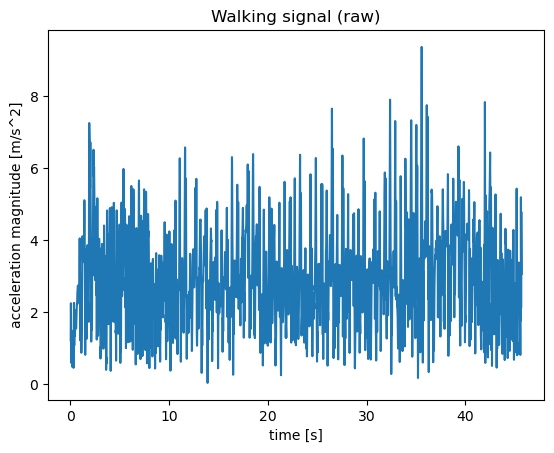

In [25]:
amag = np.sqrt(ax**2 + ay**2 + az**2)
plt.figure()
plt.plot(t, amag)
plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s^2]")
plt.title("Walking signal (raw)")
plt.show()


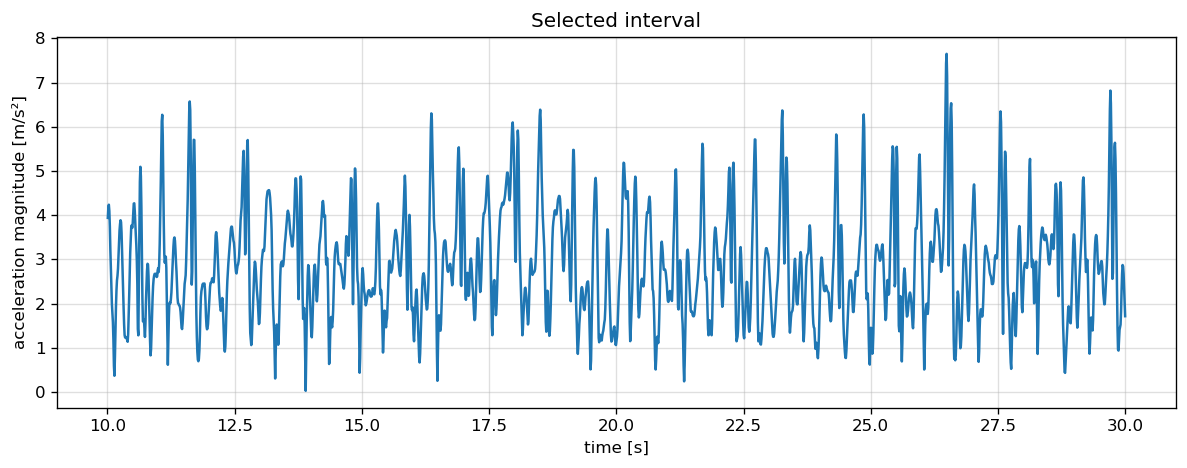

In [ ]:
t_start = 10.0
t_end   = 30.0

# selected interval = si

si = (t >= t_start) & (t <= t_end)
t_si = t[si]
a_si = amag[si]

plt.figure(figsize=(10,4), dpi=120)
plt.plot(t_si, a_si, linewidth=1.5)
plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Selected interval")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


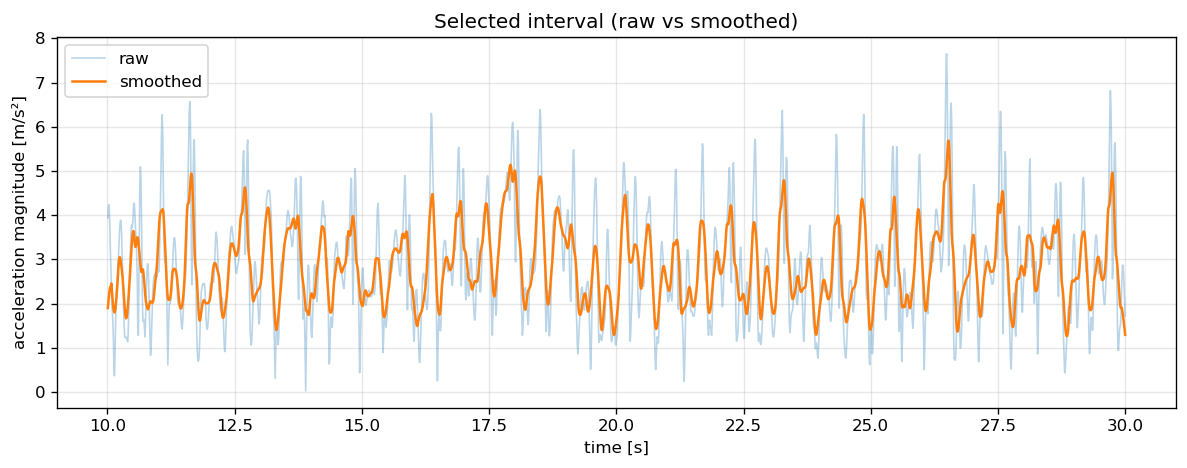

In [ ]:
window = 15
window_avrage = np.ones(window) / window
a_smooth = np.convolve(a_si, window_avrage, mode="same")

plt.figure(figsize=(10,4), dpi=120)
plt.plot(t_si, a_si, alpha=0.3, linewidth=1, label="raw")
plt.plot(t_si, a_smooth, linewidth=1.5, label="smoothed")
plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Selected interval (raw vs smoothed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
window = 15
window_average = np.ones(window) / window
a_smooth = np.convolve(a_si, window_average, mode="same")
a_centered = a_smooth - np.mean(a_smooth)

threshold = 0.25 * np.max(a_centered)
min_time_between_steps = 0.5
#average taken from the internet and experiment done by myself

# converting index to seconds
dt = np.mean(np.diff(t_si))          
min_distance = int(min_time_between_steps / dt)

peak_idx = []
last = -10**9

for i in range(1, len(a_centered) - 1):
    is_peak = (a_centered[i] > a_centered[i-1]) and (a_centered[i] > a_centered[i+1])
    high_enough = a_centered[i] > threshold
    far_enough = (i - last) >= min_distance

    if is_peak and high_enough and far_enough:
        peak_idx.append(i)
        last = i

peak_idx = np.array(peak_idx, dtype=int)
len(peak_idx)


27

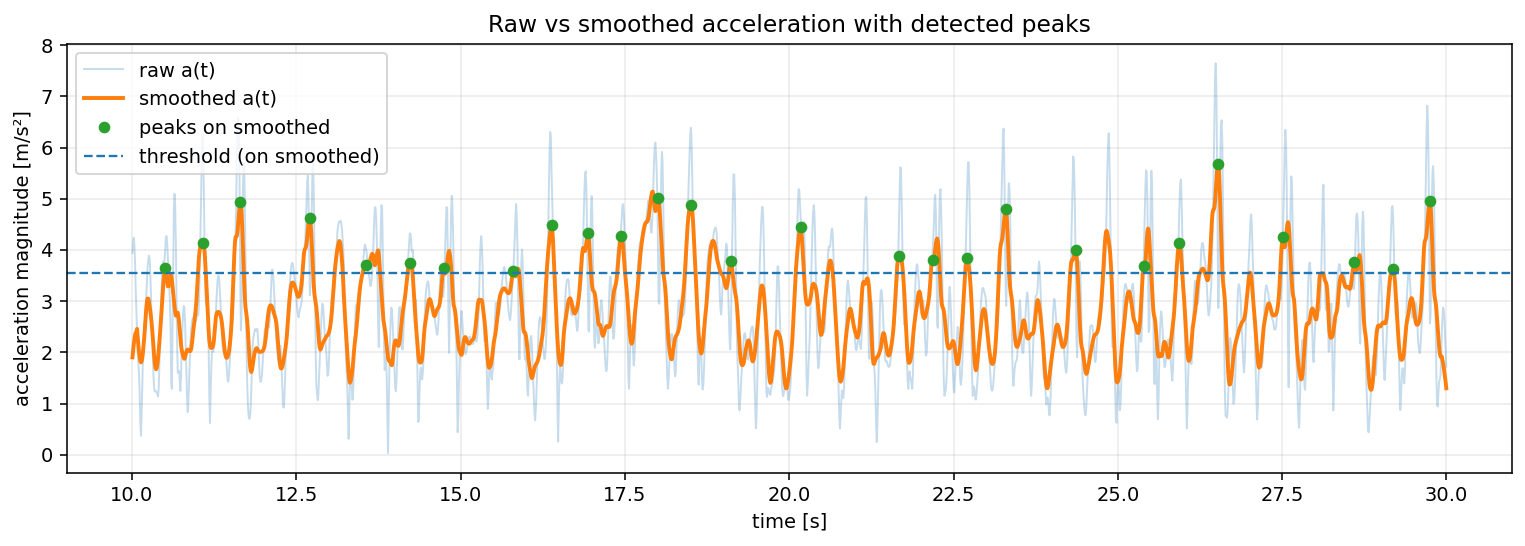

In [ ]:
plt.figure(figsize=(11,4), dpi=140)

plt.plot(t_si, a_si, alpha=0.25, linewidth=1, label="raw a(t)")
plt.plot(t_si, a_smooth, linewidth=2, label="smoothed a(t)")
plt.plot(t_si[peak_idx], a_smooth[peak_idx], "o", markersize=5, label="peaks on smoothed")

plt.axhline(np.mean(a_smooth) + threshold, linestyle="--", linewidth=1.2, label="threshold (on smoothed)")

plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Raw vs smoothed acceleration with detected peaks")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
step_times = t_si[peak_idx]

n_steps = len(step_times)
if n_steps < 2:
    print("Not enough peaks to compute step rate. Try lowering threshold or min_step_time.")
else:
    
    intervals = np.diff(step_times)

    
    mean_dt = np.mean(intervals)
    min_dt  = np.min(intervals)
    max_dt  = np.max(intervals)

    
    f_hz = 1.0 / mean_dt
    spm = 60.0 * f_hz

    
    print("=== Step detection results ===")
    print(f"Detected steps: {n_steps:d}")
    print(f"Mean time between steps: {mean_dt:.3f} s  (min {min_dt:.3f} s, max {max_dt:.3f} s)")
    print(f"Step frequency: {f_hz:.3f} Hz")
    print(f"pace: {spm:.1f} steps/min")


=== Step detection results ===
Detected steps: 27
Mean time between steps: 0.740 s  (min 0.500 s, max 1.499 s)
Step frequency: 1.351 Hz
pace: 81.1 steps/min


In [ ]:
# Runing Data = rd
rd = pd.read_csv("Raw Data Running.csv")
rd.head()


,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.002548,0.725329,1.099974,-2.619911,2.932572
1,0.012542,0.788071,1.212727,-2.342346,2.752880
2,0.022536,0.863538,1.483202,-1.895683,2.557186
3,0.032530,0.841651,1.674079,-1.729945,2.550221
4,0.042524,0.843385,1.726188,-1.565904,2.478524


In [ ]:
t_r  = rd.iloc[:, 0].to_numpy()
ax_r = rd.iloc[:, 1].to_numpy()
ay_r = rd.iloc[:, 2].to_numpy()
az_r = rd.iloc[:, 3].to_numpy()


In [ ]:
amag_r = np.sqrt(ax_r**2 + ay_r**2 + az_r**2)


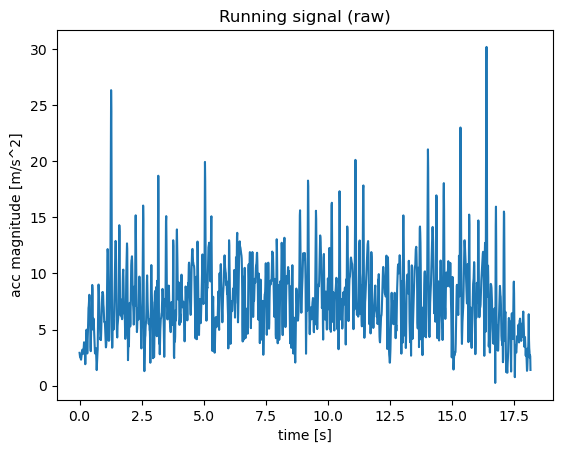

In [ ]:
plt.figure()
plt.plot(t_r, amag_r)
plt.xlabel("time [s]")
plt.ylabel("acc magnitude [m/s^2]")
plt.title("Running signal (raw)")
plt.show()


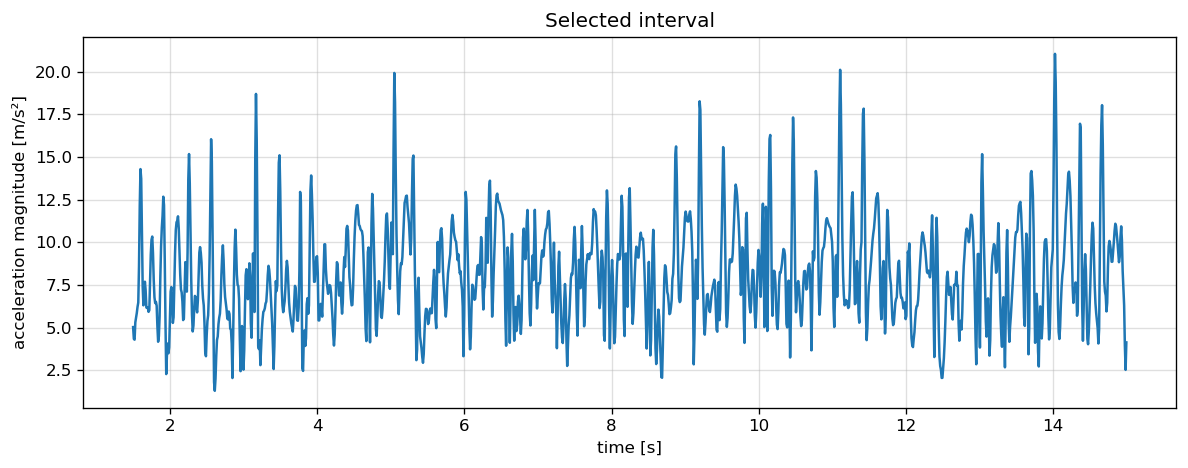

In [ ]:
t_start = 1.5
t_end   = 15.0

si = (t_r >= t_start) & (t_r <= t_end)
t_si_r = t_r[si]
a_si_r = amag_r[si]

plt.figure(figsize=(10,4), dpi=120)
plt.plot(t_si_r, a_si_r, linewidth=1.5)
plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Selected interval")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


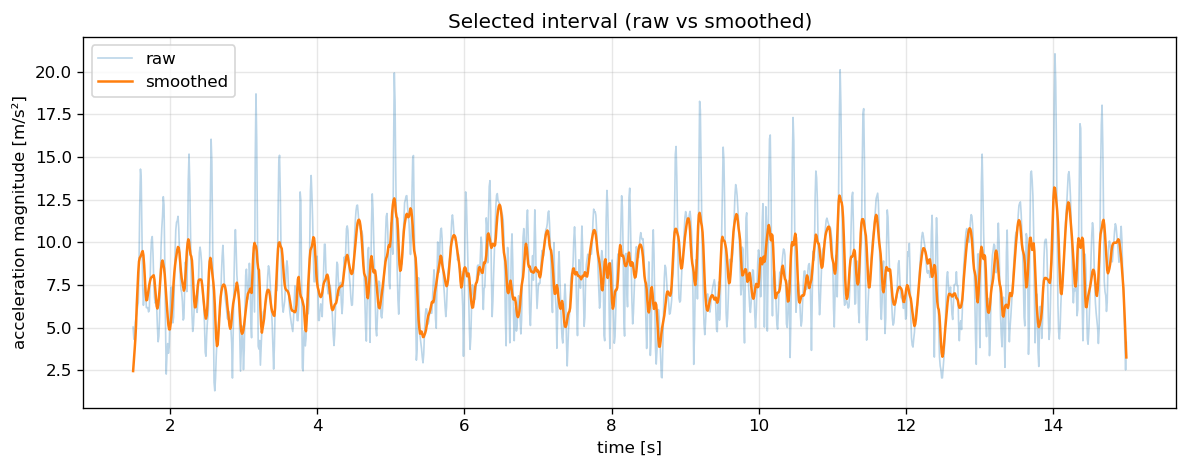

In [ ]:
window = 10
window_avrage = np.ones(window) / window
a_smooth = np.convolve(a_si_r, window_avrage, mode="same")

plt.figure(figsize=(10,4), dpi=120)
plt.plot(t_si_r, a_si_r, alpha=0.3, linewidth=1, label="raw")
plt.plot(t_si_r, a_smooth, linewidth=1.5, label="smoothed")
plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Selected interval (raw vs smoothed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
window = 10
window_average = np.ones(window) / window
a_smooth_r = np.convolve(a_si_r, window_average, mode="same")
a_centered_r = a_smooth_r - np.mean(a_smooth_r)

threshold = 0.25 * np.max(a_centered_r)
min_step_time = 0.10   # running = faster steps

dt = np.mean(np.diff(t_si_r))
min_distance = int(min_step_time / dt)

peak_idx_r = []
last = -10**9

for i in range(1, len(a_centered_r) - 1):
    is_peak = (a_centered_r[i] > a_centered_r[i-1]) and (a_centered_r[i] > a_centered_r[i+1])
    high = a_centered_r[i] > threshold
    far = (i - last) >= min_distance

    if is_peak and high and far:
        peak_idx_r.append(i)
        last = i

peak_idx_r = np.array(peak_idx_r)
len(peak_idx_r)


41

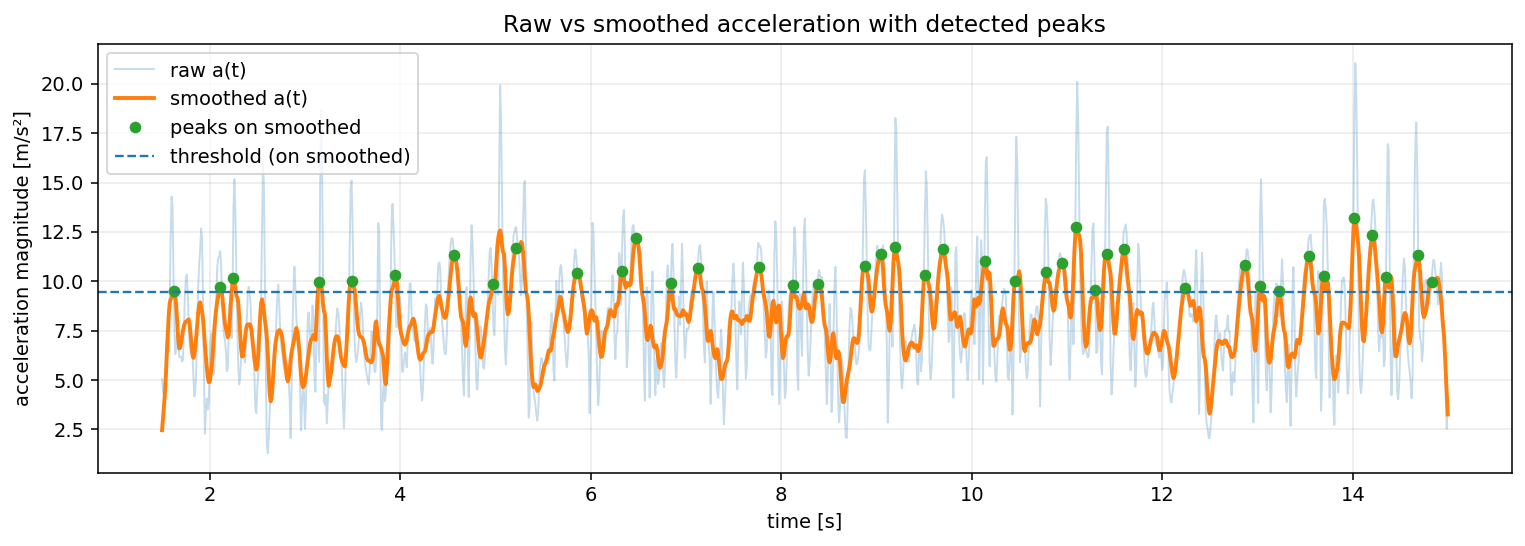

In [ ]:
plt.figure(figsize=(11,4), dpi=140)

plt.plot(t_si_r, a_si_r, alpha=0.25, linewidth=1, label="raw a(t)")
plt.plot(t_si_r, a_smooth_r, linewidth=2, label="smoothed a(t)")
plt.plot(t_si_r[peak_idx_r], a_smooth_r[peak_idx_r], "o", markersize=5, label="peaks on smoothed")

plt.axhline(np.mean(a_smooth_r) + threshold, linestyle="--", linewidth=1.2, label="threshold (on smoothed)")

plt.xlabel("time [s]")
plt.ylabel("acceleration magnitude [m/s²]")
plt.title("Raw vs smoothed acceleration with detected peaks")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
step_times_r = t_sel_r[peak_idx_r]
intervals_r = np.diff(step_times_r)

mean_dt_r = np.mean(intervals_r)
f_r = 1.0 / mean_dt_r
spm_r = 60 * f_r

print("Running step frequency:", f_r, "Hz")
print("Running pace:", spm_r, "steps/min")


Running step frequency: 2.067046906478002 Hz
Running pace: 124.02281438868012 steps/min


### Conclusion

In this task, phone accelerometer data was used to measure step frequency during walking and running.
The acceleration magnitude was calculated and peaks in the signal were used to detect individual steps.

The results were realistic, with running showing a higher step frequency than walking. The same method
can be applied to similar data sets, which means the results are repeatable.

In [1]:
%reset -f


<h2 style="color:#F5F527;">Task 2-Elevator - power estimation </h2>


### Aim

The aim of this experiment was to estimate the power output of the elevator in the Traverse building using accelerometer data recorded with a smartphone.

**What we will do:**
1. Load the recorded time-series data from `Raw Data Elevator.csv`.
2. Choose a time interval where the Elevator door closes till it opens again .
3. integrate the acceleration to obtain velocity and height.
4. Use the calculated velocity and acceleration to estimate the elevator motor power.

In [5]:
#Imoports for Task 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# cumulative integration
try:
    from scipy.integrate import cumulative_trapezoid as cumtrapz
except ImportError:
    from scipy.integrate import cumtrapz


In [6]:
csv_file = "Raw Data Elevator.csv"
# Eevator Data = ed
ed = pd.read_csv(csv_file)

print("COLUMNS:")
print(list(ed.columns))
print("\nFIRST ROWS:")
display(ed.head())
# to inspect the data before entangling it with math .


COLUMNS:
['Time (s)', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)', 'Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)']

FIRST ROWS:


,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.001655,0.081131,0.055385,9.836196,9.836686
1,0.011649,0.074395,0.048649,9.836944,9.837346
2,0.021643,0.051194,0.073347,9.818682,9.819089
3,0.031637,0.029638,0.089514,9.858200,9.858651
4,0.041631,0.042362,0.076641,9.828711,9.829101


In [7]:

# Use of AI:
# AI assistance was used only to transcribe column names from screenshots
# of the data file into Python code, in order to avoid spelling mistakes
# and save time. No analysis decisions or interpretation of results were
# generated by AI.

t  = ed["Time (s)"].to_numpy(float)
ax = ed["Acceleration x (m/s^2)"].to_numpy(float)
ay = ed["Acceleration y (m/s^2)"].to_numpy(float)
az = ed["Acceleration z (m/s^2)"].to_numpy(float)

a_mag = ed["Absolute acceleration (m/s^2)"].to_numpy(float)

# For easier and cleaner integration, the time array was shifted
# so that it starts at t = 0
t = t - t[0]

print("t range:", t[0], "to", t[-1])
print("a_mag first values:", a_mag[:5])



t range: 0.0 to 21.92671549665
a_mag first values: [9.83668604 9.83734558 9.81908936 9.85865071 9.82910118]


Estimated g = 9.8418 m/s^2 (should be ~9.81)


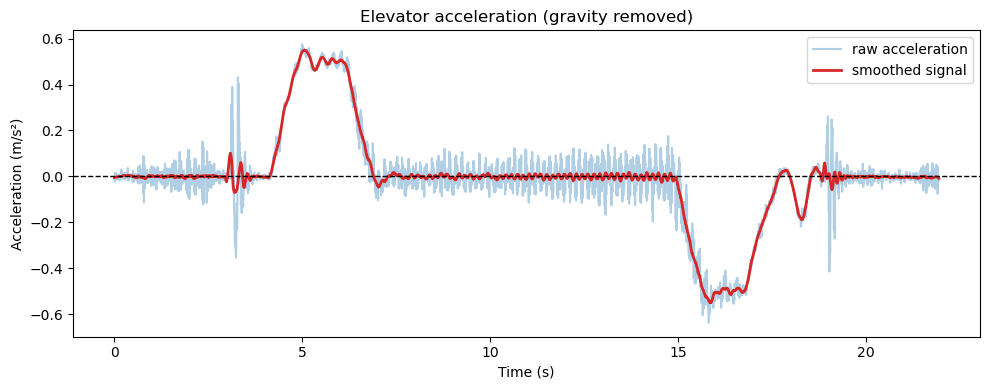

In [8]:
# Estimation of before elevator starts to move .
still_window = 2.0
mask_still = t <= still_window
# boolean masking Python Data Science Handbook

gravity = np.median(a_mag[mask_still])
print(f"Estimated g = {gravity:.4f} m/s^2 (should be ~9.81)")

# Elevator acceleration (gravity removed)
a = a_mag - gravity
#a ≈ 0 = elevator constant speed or standing
#a > 0 = accelerating upward
#a < 0 = braking

from scipy.signal import savgol_filter
a_smooth = savgol_filter(a, window_length=31, polyorder=3)

plt.figure(figsize=(10, 4))
plt.plot(t, a, color="tab:blue", alpha=0.35, label="raw acceleration")
plt.plot(t, a_smooth, color="tab:red", linewidth=2, label="smoothed signal")

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Elevator acceleration (gravity removed)")
plt.legend()
plt.tight_layout()
plt.show()



Window length: 0.0 to 17.989099462000002 seconds


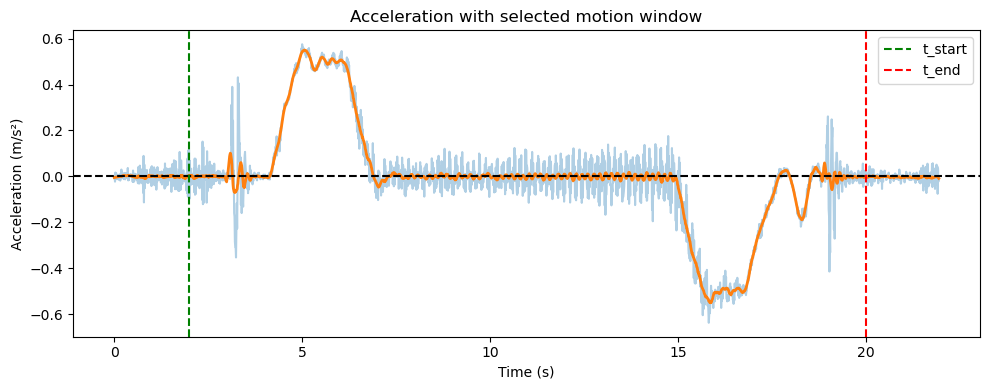

In [9]:
t_start = 2.0   # based on a/s plot
t_end   = 20.0  # based on a/s plot
mask = (t >= t_start) & (t <= t_end)
t2 = t[mask]
a2 = a[mask]


t2 = t2 - t2[0]

print("Window length:", t2[0], "to", t2[-1], "seconds")

plt.figure(figsize=(10, 4))
plt.plot(t, a, alpha=0.35)
plt.plot(t, a_smooth, linewidth=2)

plt.axhline(0, linestyle="--", color="black")
plt.axvline(t_start, linestyle="--", color="green", label="t_start")
plt.axvline(t_end, linestyle="--", color="red", label="t_end")

plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration with selected motion window")
plt.legend()
plt.tight_layout()
plt.show()


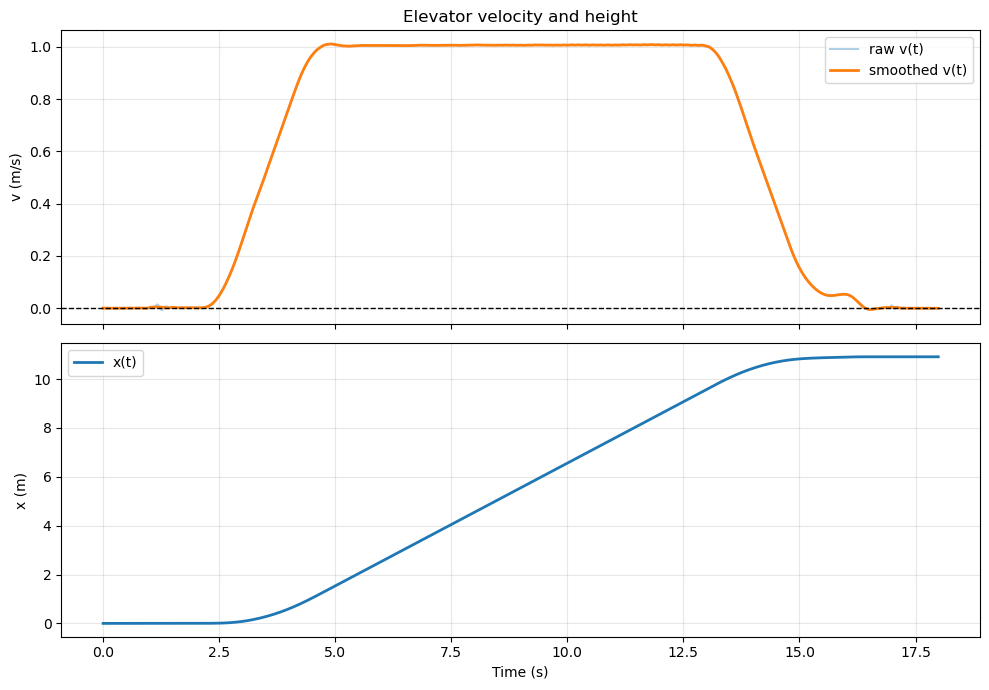

In [11]:
try:
    from scipy.integrate import cumulative_trapezoid as cumtrapz
except ImportError:
    from scipy.integrate import cumtrapz

def cumint(y, x):
    try:
        return cumtrapz(y, x, initial=0)
    except TypeError:
        out = cumtrapz(y, x)
        return np.concatenate(([0.0], out))

v2 = cumint(a2, t2)      # velocity from integrating acceleration
x2 = cumint(v2, t2)      # position from integrating velocity


v_drift = np.linspace(v2[0], v2[-1], len(v2))
v2c = v2 - v_drift


x2c = cumint(v2c, t2)

from scipy.signal import savgol_filter
v_smooth = savgol_filter(v2c, 51, 3)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 7))

axs[0].plot(t2, v2c, alpha=0.35, label="raw v(t)")
axs[0].plot(t2, v_smooth, linewidth=2, label="smoothed v(t)")
axs[0].axhline(0, linestyle="--", color="black", linewidth=1)
axs[0].set_ylabel("v (m/s)")
axs[0].set_title("Elevator velocity and height")
axs[0].grid(True, alpha=0.3)
axs[0].legend()


axs[1].plot(t2, x2c, linewidth=2, label="x(t)")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("x (m)")
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()


Discussion: these 2 plots also support the choice made for t_start and t_End

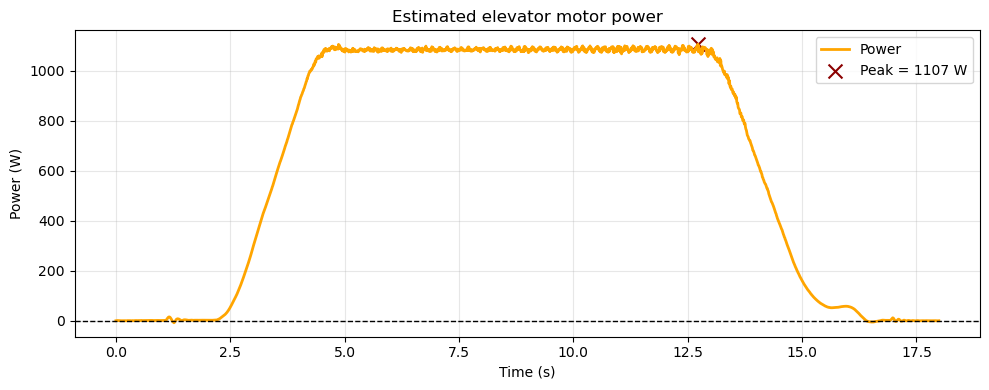

Height travelled (m): 10.91159491817804
Max speed (m/s): 1.0117499812450141
Peak power (W): 1106.5996145135687


In [18]:
m = 110
g = 9.81

F2 = m * (g + a2)  # Newton
P2 = F2 * v2c      # Watt

i_peak = np.argmax(P2)

plt.figure(figsize=(10,4))
plt.plot(t2, P2, color="orange", linewidth=2, label="Power")
plt.scatter(t2[i_peak], P2[i_peak],color="darkred", marker="x", s=100,label=f"Peak = {P2[i_peak]:.0f} W")

plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")
plt.title("Estimated elevator motor power")
plt.legend()
plt.tight_layout()
plt.show()


print("Height travelled (m):", float(x2c[-1] - x2c[0]))
print("Max speed (m/s):", float(np.max(v2c)))
print("Peak power (W):", float(np.max(P2)))


## Discussion

The power analysis shows a maximum power output of approximately **1107 W**, which occurs during the acceleration phase when both velocity and acceleration are nonzero.  
The calculation assumes a balanced counterweight and neglects friction and efficiency losses, meaning the result should be interpreted as a realistic estimate rather than the exact motor power.

The calculated height of approximately **10.9 m** is consistent with the elevator traveling about three floors.  
Small deviations are expected and can be attributed to sensor noise and numerical errors introduced during the integration process.


## Conclusion

Smartphone accelerometer data were used to analyze the motion and power output of an elevator in the Traverse building.  
The calculated vertical displacement of approximately **10.9 m** confirms that the elevator traveled three floors, while the estimated maximum power output of **1107 W** is physically realistic.

These results demonstrate that meaningful physical quantities can be extracted from smartphone sensor data using basic numerical methods.


In [50]:
%reset -f



<h2 style="color:#A659F0;">Task 3 — Swing: Damped Oscillation</h2>


### Aim (Swing)

In this task we study the motion of a playground swing as a **damped oscillator** using the data we got from the app.

**What we will do:**
1. Load the recorded time-series data from `swing.csv`.
2. Choose a clean time interval where the swing motion is regular.
3. Plot the measured signal and identify the oscillations, which are the peaks.
4. Estimate the **oscillation period / frequency** from the peak spacing.
5. Estimate the **damping** by tracking how the peak amplitudes decay over time (exponential envelope).
6. Summarize the results and discuss limitations (sensor noise, phone orientation, filtering and others).


In [51]:
#Imports for task 3
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Small plot defaults so figures are readable
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

In [ ]:
swing_path = Path("data/swing/swing.csv")

with open(swing_path, "r", encoding="utf-8") as f:
    header = f.readline().strip()
# We opened the file and checked the first line which contains the column names and units.
data = np.loadtxt(swing_path, delimiter=",", skiprows=1)

print("Header:", header)
print("Data shape (rows, cols):", data.shape)



Header: "Time (s)","Acceleration x (m/s^2)","Acceleration y (m/s^2)","Acceleration z (m/s^2)","Absolute acceleration (m/s^2)"
Data shape (rows, cols): (19214, 5)


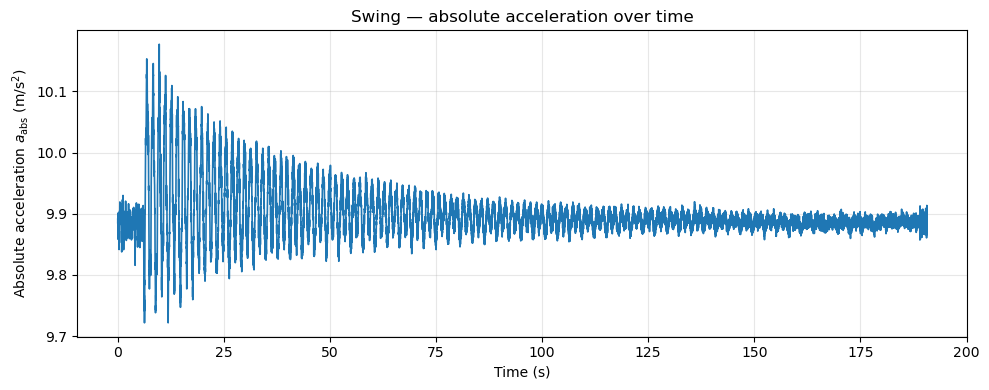

In [53]:
#Raw measurements
# Columns from header:
# 0 = Time (s)
# 1 = Acceleration x (m/s^2)
# 2 = Acceleration y (m/s^2)
# 3 = Acceleration z (m/s^2)
# 4 = Absolute acceleration (m/s^2)

t = data[:, 0]
ax = data[:, 1]
ay = data[:, 2]
az = data[:, 3]
a_abs = data[:, 4]


plt.plot(t, a_abs, linewidth=1.2)
plt.xlabel("Time (s)")
plt.ylabel(r"Absolute acceleration $a_{\mathrm{abs}}$ (m/s$^2$)")
plt.title("Swing — absolute acceleration over time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



We ignore the start-up phase and anylyze t in the interval [5.95,120] s. Then we substract the mean of a_abs to remove constant offset (which is g)

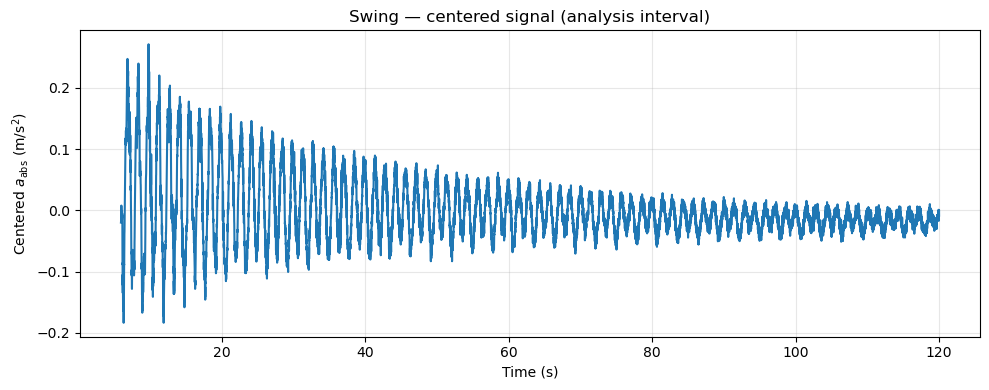

In [54]:
#"Cleaning" the graph
t = data[:, 0]
a_abs = data[:, 4]

t_min = 5.95
t_max = 120
mask = (t >= t_min) & (t <= t_max)

t_fit = t[mask]
a_fit_centered = a_abs[mask] - np.mean(a_abs[mask])

plt.plot(t_fit, a_fit_centered)
plt.xlabel("Time (s)")
plt.ylabel(r"Centered $a_{\mathrm{abs}}$ (m/s$^2$)")
plt.title("Swing — centered signal (analysis interval)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



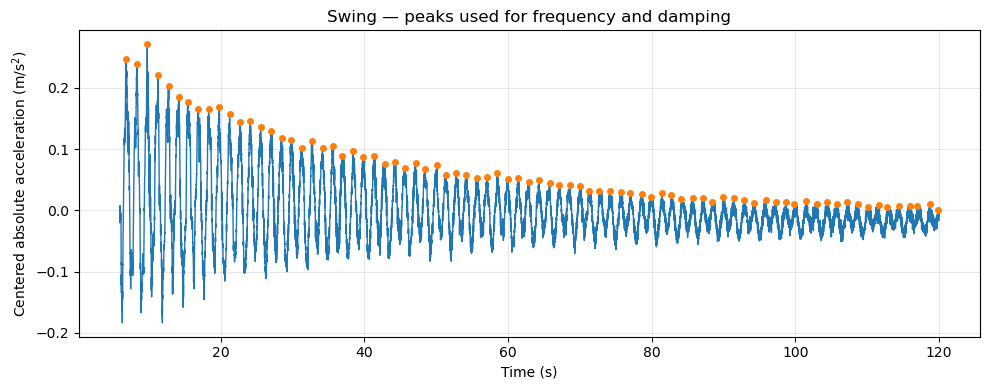

In [55]:
from scipy.signal import find_peaks

# We find peaks in the centered signal (maxima of each oscillation)
dt = np.mean(np.diff(t_fit))
#we get the differences between time values and the mean gives us dt (average sampling time)
min_period_guess = 1.0          # we take a minimum expected time between peaks so the algorith doesnt detect small bumps as peaks
min_distance = int(min_period_guess / dt)
#distance is the minimum number of samples between two detected peaks

peaks, _ = find_peaks(a_fit_centered, distance=min_distance)

plt.plot(t_fit, a_fit_centered, linewidth=1.0)
plt.plot(t_fit[peaks], a_fit_centered[peaks], "o", markersize=4)
plt.xlabel("Time (s)")
plt.ylabel(r"Centered absolute acceleration (m/s$^2$)")
plt.title("Swing — peaks used for frequency and damping")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [56]:
# Peak times extracted from the centered acceleration signal
t_peaks = t_fit[peaks]

# We are using acceleration magnitude.
# This type of signal often produces two maxima per one full swing cycle
# (one for the forward extreme and one for the backward extreme)..
# To estimate the period of the actual swing cycle, we use every second peak.
t_peaks_cycle = t_peaks[::2]

# The swing period T is the typical time, difference between consecutive cycle peaks
T_est = np.median(np.diff(t_peaks_cycle)) 

# We then convert period to angular frequency: omega = 2*pi / T
omega_d_est = 2*np.pi / T_est              

# Formatting note: :.3f prints 3 digits after the decimal point
print(f"Estimated period (cycle) T ≈ {T_est:.3f} s")
print(f"Estimated omega_d ≈ {omega_d_est:.3f} rad/s")


Estimated period (cycle) T ≈ 2.878 s
Estimated omega_d ≈ 2.183 rad/s


### Estimating damping from peak amplitudes (log method)

A swing behaves like a *damped* oscillator: the oscillations keep going, but the amplitude slowly decreases.

A common model for damped oscillations is:

$$x(t) = A\,e^{-b t}\cos(\omega_d t + \phi)$$

The important part for damping is the exponential envelope $A\,e^{-bt}$.
If we look at the peak amplitudes $A(t)$ over time, they should follow:

$$A(t) \approx A_0 e^{-bt}$$

Taking the natural logarithm makes this linear:

$$\ln(A(t)) = \ln(A_0) - bt$$

So if we plot $\ln(A)$ vs. $t$, we expect a straight line.
The slope is $-b$, which we estimate using a line fit.

The decay rate is related by

$$b = \zeta\,\omega_0$$

and we can estimate

$$\zeta \approx \frac{b}{\omega_0}.$$


Decay rate b ≈ 0.0332 1/s


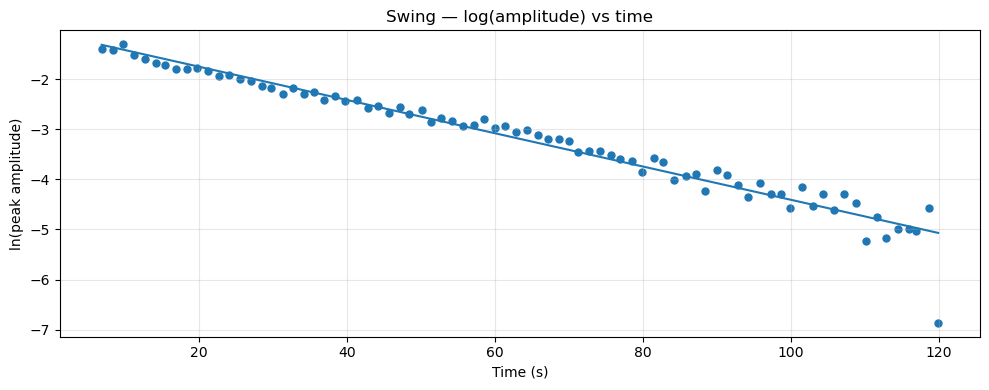

In [57]:
# Peak amplitudes (we used the absolute value so we can take the ln)
A = np.abs(a_fit_centered[peaks])
tA = t_fit[peaks]

lnA = np.log(A)

# np.polyfit(x, y, 1) fits a straight line y ≈ m*x + c 
m, c = np.polyfit(tA, lnA, 1)

# ln(A) = ln(A0) - b*t so the  slope m = -b
b_est = -m

print(f"Decay rate b ≈ {b_est:.4f} 1/s")

plt.scatter(tA, lnA, s=25)
plt.plot(tA, m*tA + c)
plt.xlabel("Time (s)")
plt.ylabel("ln(peak amplitude)")
plt.title("Swing — log(amplitude) vs time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [58]:
g = 9.81
L = 1.97 #measure from the swing in the park  

omega0_theory = np.sqrt(g / L)

# For light damping, omega_d is almost omega0 
omega0_est = omega_d_est

zeta_est = b_est / omega0_est

print(f"omega0 (theory) = {omega0_theory:.3f} rad/s")
print(f"omega0 (data)   = {omega0_est:.3f} rad/s")
print(f"zeta (data)     = {zeta_est:.4f}")
print(f"relative difference = {(omega0_est-omega0_theory)/omega0_theory*100:.1f}%")


omega0 (theory) = 2.232 rad/s
omega0 (data)   = 2.183 rad/s
zeta (data)     = 0.0152
relative difference = -2.2%


### Results (Swing)

From the measured acceleration magnitude we detected peaks and estimated the oscillation period.  
Because the acceleration magnitude can produce two maxima per swing cycle, we used every second detected peak to represent one full cycle.

- Measured angular frequency: $\omega_0 \approx 2.183\ \text{rad/s}$
- Theoretical angular frequency (simple pendulum): $\omega_{0,\text{theory}}=\sqrt{g/L}\approx 2.232\ \text{rad/s}$ for $L=1.97\ \text{m}$
- Relative difference: $-2.2\%$
- Estimated damping ratio: $\zeta \approx 0.0152$

The measured and theoretical frequencies agree within a few percent, which is consistent with a small-angle pendulum model.  
Remaining differences can come from non-small angles, uncertainty in the effective length (pivot to phone position), and the fact that the phone acceleration magnitude is not a direct measurement of the swing angle.


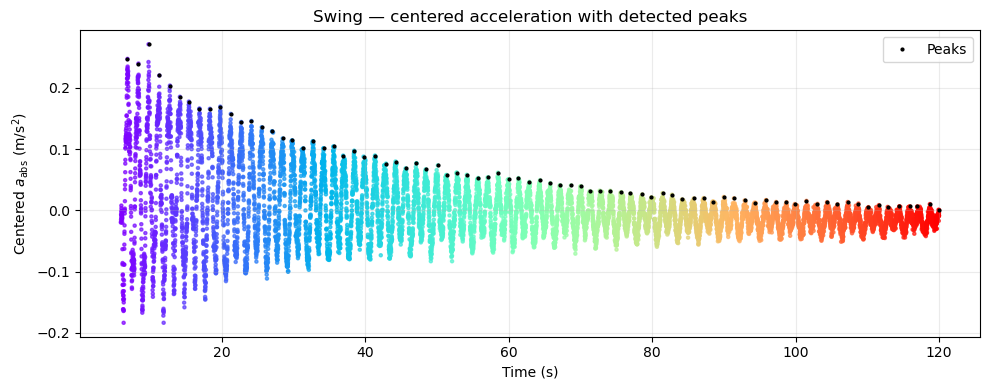

In [59]:

#Nicely colored rainbow graph
#Figure X shows the centered acceleration of the swing as a function of time. 
#The oscillatory motion with a gradually decreasing amplitude indicates damped harmonic motion due to energy losses from air resistance and friction at the pivot. 
#The detected peaks (black markers) are were used to extract the oscillation period and to analyze the decay of the oscillation amplitude over time.


fig, a_abs_time = plt.subplots()

a_abs_time.scatter(
    t_fit, a_fit_centered,
    c=t_fit, cmap="rainbow",
    s=5, alpha=0.7
)

a_abs_time.plot(t_fit[peaks], a_fit_centered[peaks], "k.", markersize=4, label="Peaks")

a_abs_time.set_xlabel("Time (s)")
a_abs_time.set_ylabel(r"Centered $a_{\mathrm{abs}}$ (m/s$^2$)")
a_abs_time.set_title("Swing — centered acceleration with detected peaks")
a_abs_time.grid(True, alpha=0.25)
a_abs_time.legend()
plt.tight_layout()



In [64]:
%reset -f


<h2 style="color:#A659F0;">Task 4 — Merry-go-round (Rotational motion)</h2>


In this task we investigate rotational motion using smartphone sensors on a playground merry-go-round.  
Two datasets were recorded (it should be noted that we had 2 separate trials, one for each dataset): **gyroscope** data to measure angular velocity and **accelerometer** data to estimate centripetal acceleration.Since the accelerometer and gyroscope were recorded in separate runs, the signals do not match in time and were analyzed independently. 

### Sensors used
- **Gyroscope:** angular speed $\,\omega(t)\,$ in rad/s  
- **Accelerometer:** acceleration $\,a(t)\,$ in m/s^2 (used to estimate centripetal acceleration during steady spinning)

### Aims
1. Extract the angular speed $\,\omega(t)\,$ and describe the different phases of the motion (push phase vs. coasting).
2. Investigate damping by analyzing how $\,\omega(t)\,$ decreases over time after pushing stops.
3. Use a steady coasting interval to estimate an **effective radius** using the circular-motion relation:

$$
a_c \approx \omega^2 r
$$

### Physical model

During steady rotation, the phone moves approximately in uniform circular motion at a fixed distance $r$ from the rotation axis.  
For circular motion with angular speed $\omega$, the centripetal acceleration is given by

$$
a_c = \omega^2 r,
$$

where
- $a_c$ is the centripetal acceleration (m/s²),
- $\omega$ is the angular speed (rad/s),
- $r$ is the distance from the rotation axis to the phone (m).


Rearranging this relation allows an estimate of an effective radius:

$$
r_{\text{eff}} = \frac{a_c}{\omega^2}.
$$

Again, because the accelerometer and gyroscope data were recorded in separate trials, this relation is applied using **mean values** of $a_c$ and $\omega$ taken from time intervals where the rotation is approximately steady.

In addition, damping of the rotation can be described by the decrease of angular speed over time.  
After the pushing stops, frictional torques cause $\omega(t)$ to decrease, which can be analyzed qualitatively by inspecting the slope of $\omega(t)$ during the coasting phase.

<small style="color:#bbbbbb;">* Since this experiment was self-designed, it includes more detailed explanation compared to the other tasks.</small>




In [69]:
#Imports for task 4
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [70]:
gyro_path = Path("data/merry_gyro/merry_gyro.csv")

# We then opened the file to read the header line
# The header contains the column names and units
with open(gyro_path, "r", encoding="utf-8") as f:
    gyro_header = f.readline().strip()

# We then loaded the numerical data from the file
# The header row was skipped so that only numerical values were stored in the array
gyro_data = np.loadtxt(gyro_path, delimiter=",", skiprows=1)

print("Gyro header:", gyro_header)
print("Gyro data shape (rows, cols):", gyro_data.shape)


Gyro header: "Time (s)","Gyroscope x (rad/s)","Gyroscope y (rad/s)","Gyroscope z (rad/s)","Absolute (rad/s)"
Gyro data shape (rows, cols): (14278, 5)


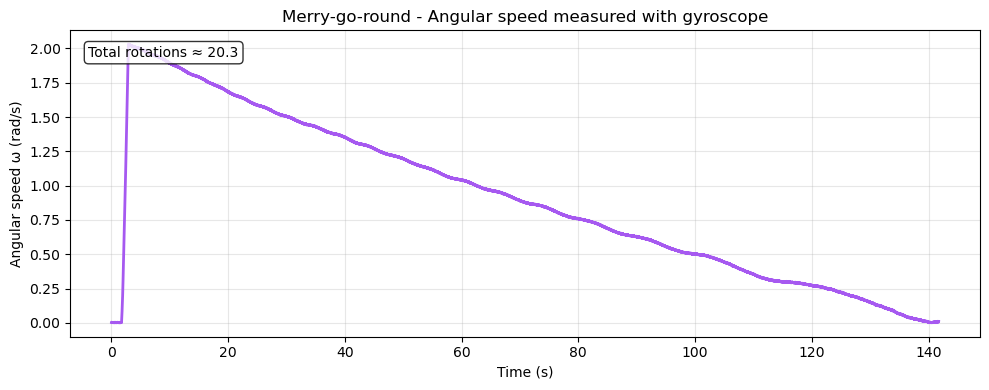

In [71]:
from scipy import integrate  

# The gyroscope CSV has the following columns (from the header):
# column 0: Time (s)
# column 1: Gyroscope x (rad/s)
# column 2: Gyroscope y (rad/s)
# column 3: Gyroscope z (rad/s)
# column 4: Absolute angular speed (rad/s)

# We then extract the time and the angular speed
t_g = gyro_data[:, 0]
omega = gyro_data[:, 4]

# We integrated angular speed over time to obtain total angular displacement
# This gives the total angle in radians rotated during the experiment
theta_total = integrate.simpson(y=omega, x=t_g)


# After getting that value we can convert it to the number of full rotations
n_rotations = theta_total / (2 * np.pi)

plt.figure(figsize=(10, 4))
plt.plot(t_g, omega, color="#A659F0", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Angular speed ω (rad/s)")
plt.title("Merry-go-round - Angular speed measured with gyroscope")

#After calculating the total number of rotations, I added this value as text inside the plot so that the main result is visible together with the measured data
plt.text(0.02,0.95,f"Total rotations ≈ {n_rotations:.1f}",transform=plt.gca().transAxes, verticalalignment="top",bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [72]:

acc_path = Path("data/merry_acc/merry_acc.csv")

with open(acc_path, "r", encoding="utf-8") as f:
    acc_header = f.readline().strip()

acc_data = np.loadtxt(acc_path, delimiter=",", skiprows=1)

print("Accelerometer header:", acc_header)
print("Accelerometer data shape (rows, cols):", acc_data.shape)


Accelerometer header: "Time (s)","Acceleration x (m/s^2)","Acceleration y (m/s^2)","Acceleration z (m/s^2)","Absolute acceleration (m/s^2)"
Accelerometer data shape (rows, cols): (20134, 5)


### Estimating centripetal acceleration from accelerometer data

During steady rotation, the centripetal acceleration points mainly in the horizontal plane (towards the center of the merry-go-round).  
The accelerometer measured acceleration components along the phone axes ($a_x, a_y, a_z$). To obtain a simple estimate of the centripetal acceleration, we used the horizontal magnitude


a_c =sqrt(a_x^2 + a_y^2).


This value was used as a proxy for a_c during the steady spinning phase, where the motion was approximately uniform and the horizontal acceleration was dominated by centripetal acceleration.


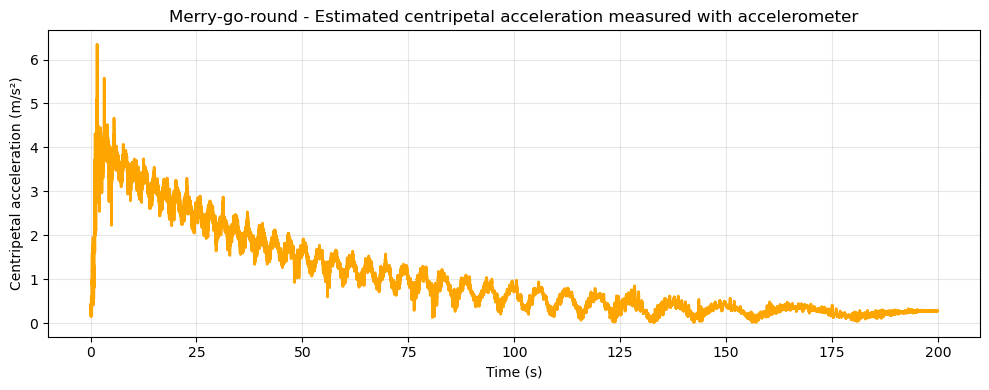

In [73]:
# The accelerometer CSV had the following columns (from the header):
# column 0: Time (s)
# column 1: Acceleration x (m/s^2)
# column 2: Acceleration y (m/s^2)
# column 3: Acceleration z (m/s^2)
# column 4: Absolute acceleration (m/s^2)

# We then extracted the time values from the first column
# These values were used as the x-axis in the plot
t_a = acc_data[:, 0]

# We then extracted the horizontal acceleration components
ax = acc_data[:, 1]
ay = acc_data[:, 2]

# We then computed the horizontal acceleration magnitude
# This quantity was used as a proxy for the centripetal acceleration during rotation
a_cpp = np.sqrt(ax**2 + ay**2)

# We then created a plot of horizontal acceleration versus time
plt.figure(figsize=(10, 4))

plt.plot(t_a, a_cpp, color="orange", linewidth=2)

plt.xlabel("Time (s)")
plt.ylabel("Centripetal acceleration (m/s²)")
plt.title("Merry-go-round - Estimated centripetal acceleration measured with accelerometer")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# We then selected a steady spinning interval from the acceleration plot
t1_acc = 15   # start time
t2_acc = 25    # end time
## We created a mask to select only data points within the chosen time interval
acc_mask = (t_a >= t1_acc) & (t_a <= t2_acc)

a_mean = np.mean(a_cpp[acc_mask])
a_std  = np.std(a_cpp[acc_mask])

print(f"Selected accelerometer interval: {t1_acc:.1f} to {t2_acc:.1f} s")
print(f"Mean centripetal acceleration = {a_mean:.3f} ± {a_std:.3f} m/s²")


Selected accelerometer interval: 15.0 to 25.0 s
Mean centripetal acceleration = 2.759 ± 0.261 m/s²


In [78]:
# We then selected a steady coasting interval from the gyroscope plot
t1_gyro = 30
t2_gyro = 40

gyro_mask = (t_g >= t1_gyro) & (t_g <= t2_gyro)

omega_mean = np.mean(omega[gyro_mask])
omega_std  = np.std(omega[gyro_mask])

print(f"Selected gyroscope interval: {t1_gyro:.1f} to {t2_gyro:.1f} s")
print(f"Mean angular speed = {omega_mean:.3f} ± {omega_std:.3f} rad/s")


Selected gyroscope interval: 30.0 to 40.0 s
Mean angular speed = 1.426 ± 0.043 rad/s


In [79]:
# We then estimated an effective radius using a_c = ω²* r
r_eff = a_mean / (omega_mean**2)

print(f"Effective radius r ≈ {r_eff:.3f} m")


Effective radius r ≈ 1.356 m


### Checking how sensitive the radius estimate is

Above, we picked one “steady” interval in the accelerometer data and one “steady” interval in the gyroscope data, and we used the mean values to estimate the radius.

But because the accelerometer and gyroscope were recorded in different runs, the result depends a lot on which time windows we choose (some parts are messy).

So in the next cell we try many short time windows (same window length each time), compute a radius estimate for each window pair, and plot the radius values over time.  
We also mark “weird” values in red (above a chosen threshold) to show which windows probably were not steady / reliable.


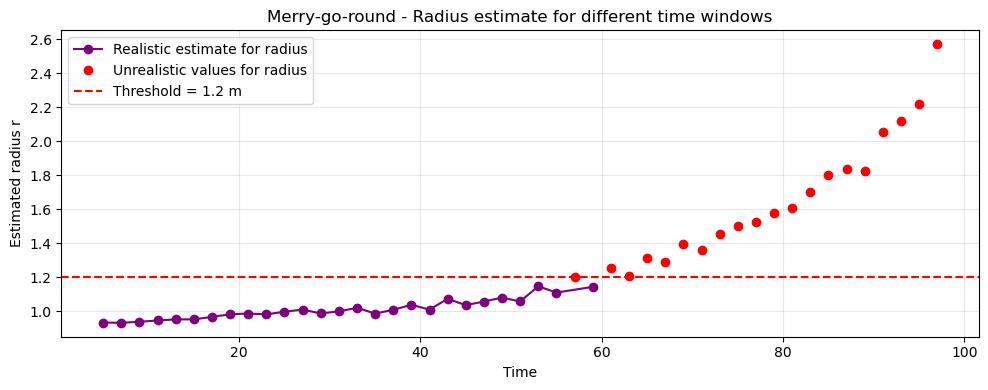

In [88]:
# We picked a fixed window length for both signals
# (we used short windows so we could test lots of different parts of the data)
window_acc = 5.0
window_gyro = 5.0

# We picked start times for the windows
# We stepped by 2 seconds so we get many samples without it taking forever
acc_times = np.arange(5, t_a.max() - window_acc, 2.0)
gyro_times = np.arange(5, t_g.max() - window_gyro, 2.0)

r_values = []
t_values = []

# We then looped through windows in both datasets (they are different runs, so this is not a perfect comparison)
for t_acc, t_gyro in zip(acc_times, gyro_times):
    
    # Then we selected a short window in the accelerometer data and take the average acceleration
    acc_mask = (t_a >= t_acc) & (t_a <= t_acc + window_acc)
    a_mean = np.mean(a_cpp[acc_mask])

    #And did the same for gyroscope
    gyro_mask = (t_g >= t_gyro) & (t_g <= t_gyro + window_gyro)
    omega_mean = np.mean(omega[gyro_mask])

    #AI suggested adding this to avoid "crazy" values (from dividing to almost zero)
    if omega_mean > 0.5 and a_mean > 0.5:
        r_est = a_mean / (omega_mean**2)
        r_values.append(r_est)
        t_values.append(t_acc)

t_values = np.array(t_values)
r_values = np.array(r_values)
# We picked a simple threshold to highlight radius estimates that look unrealistic
r_limit = 1.2
# Then split the points into normal and not
ok = r_values <= r_limit
bad = r_values > r_limit
plt.figure(figsize=(10, 4))
plt.plot(t_values[ok], r_values[ok], "o-", color="purple", label="Realistic estimate for radius")
plt.plot(t_values[bad], r_values[bad], "ro", label="Unrealistic values for radius")

plt.axhline(r_limit, color="red", linestyle="--", linewidth=1.5, label=f"Threshold = {r_limit:.1f} m")

plt.xlabel("Time")
plt.ylabel("Estimated radius r")
plt.title("Merry-go-round - Radius estimate for different time windows")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### Conclusion (Merry-go-round)

The gyroscope data clearly showed the push phase followed by a coasting phase where the angular speed decreased over time, consistent with frictional damping.  
By integrating the angular speed using SciPy, we estimated the total number of rotations during the experiment.

From the accelerometer data, the horizontal acceleration magnitude was used as a proxy for centripetal acceleration during steady spinning.  
Because the accelerometer and gyroscope were recorded in separate runs, we compared them using short steady time windows and computed an effective radius using $r \approx \bar{a}/\bar{\omega}^2$.

The estimated radius depended on which time windows were selected, which shows the sensitivity of the result to interval choice, sensor noise, and phone orientation.  
Overall, the trends matched the expected physics of circular motion and damping, but the radius estimate should be treated as an effective value rather than an exact geometric measurement.


In [26]:
%reset -f



<h2 style="color:#F5F527;">Task 5-Broken speedometer: average and max speed calculation </h2>


### Aim 

The aim of this task is to determine the average speed and the maximum speed of a scooter using smartphone GPS data . 
because the speedometer of the scooter is broken. (This is accully true, the speedometer has not worked in months!)

**What we will do:**
1. Load the recorded GPS data from `Raw Data GPS.csv`.
2. Clean the data by removing invalid or missing speed measurements.
3. Process the distance data to determine how far the scooter travelled from the starting point.
4. Plot the speed as a function of time to show how the scooter accelerates, moves at a steady speed, and slows down.
5. Calculate the average speed and the maximum speed of the scooter from the GPS data.

### Relevant equations

The **average speed** of the scooter was determined by dividing the total travelled distance by the total measurement time:

$$
v_{\text{avg}} = \frac{\Delta d}{\Delta t}
$$

where $\Delta d$ is the total distance travelled and $\Delta t$ is the total duration of the ride.

The **maximum speed** was obtained by identifying the highest speed value recorded by the GPS during the measurement.
The GPS measured speed in meters per second (m/s), while scooter speeds are typically expressed in kilometres per hour (km/h).  
Therefore, the following unit conversion was applied:

$$
v_{\text{km/h}} = 3.6 \, v_{\text{m/s}}
$$

The travelled distance was determined **relative to the starting point** of the measurement.  
Since the GPS distance does not start at zero but corresponds to an absolute position on Earth, the initial distance value was subtracted from all subsequent values:

$$
d(t) = d_{\text{GPS}}(t) - d_{\text{GPS}}(t_0)
$$

This ensures that the distance represents only the displacement during the scooter ride.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [28]:
gps = pd.read_csv("Raw Data GPS.csv")
gps.head() 
# overvieuw of the Data 

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.044906,51.461643,5.600459,19.952723,64.289928,NaN,NaN,0.855691,1414.000000,103.564903,-1.0
1,1.914543,51.457783,5.589774,29.500027,73.844182,3.08,215.156250,0.858525,7.312126,12.000000,-1.0
2,2.914553,51.457788,5.589734,19.672085,64.016208,3.12,234.492188,0.864903,4.782545,4.000000,-1.0
3,3.914564,51.457782,5.589642,18.090420,62.434522,3.12,250.312500,0.870283,3.535534,3.000000,-1.0
4,4.914573,51.457777,5.589565,17.776211,62.120294,6.14,248.554688,0.877412,3.535534,3.000000,-1.0


In [29]:
gps = gps.rename(columns={"Time (s)": "time", "Speed (m/s)": "v_ms","Distance (km)": "d_km"})
# tacking the relevant Data

In [30]:
gps[["time", "v_ms", "d_km"]].head()
# NaN means the data is not known.

,time,v_ms,d_km
0,0.044906,NaN,0.855691
1,1.914543,3.08,0.858525
2,2.914553,3.12,0.864903
3,3.914564,3.12,0.870283
4,4.914573,6.14,0.877412


In [31]:
gps = gps.dropna(subset=["v_ms"]).reset_index(drop=True)
gps[["time", "v_ms", "d_km"]].head()
# to remove NaN and have clean table.

,time,v_ms,d_km
0,1.914543,3.08,0.858525
1,2.914553,3.12,0.864903
2,3.914564,3.12,0.870283
3,4.914573,6.14,0.877412
4,5.914584,8.26,0.885403


In [32]:
# distance travelds in meters = d_m
gps["d_m"] = (gps["d_km"] - gps["d_km"].iloc[0]) * 1000
gps[["time", "d_km", "d_m"]].head()


,time,d_km,d_m
0,1.914543,0.858525,0.000000
1,2.914553,0.864903,6.377541
2,3.914564,0.870283,11.757764
3,4.914573,0.877412,18.886777
4,5.914584,0.885403,26.877749


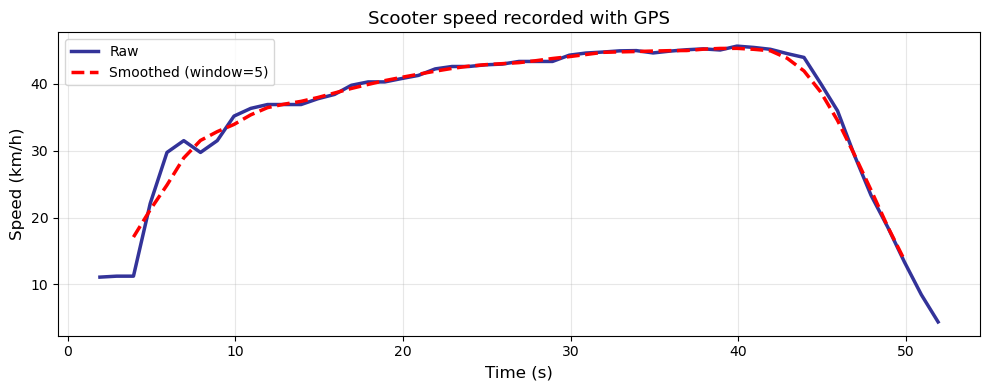

In [33]:
w = 5  
speed_kmh = gps["v_ms"] * 3.6
speed_smooth = speed_kmh.rolling(window=w, center=True).mean()

plt.figure(figsize=(10,4))
plt.plot(gps["time"], speed_kmh, linewidth=2.5, alpha=0.8, color="navy", label="Raw")
plt.plot(gps["time"], speed_smooth, linewidth=2.5, linestyle="--", color="red" , label=f"Smoothed (window={w})")

plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Speed (km/h)", fontsize=12)
plt.title("Scooter speed recorded with GPS", fontsize=13)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


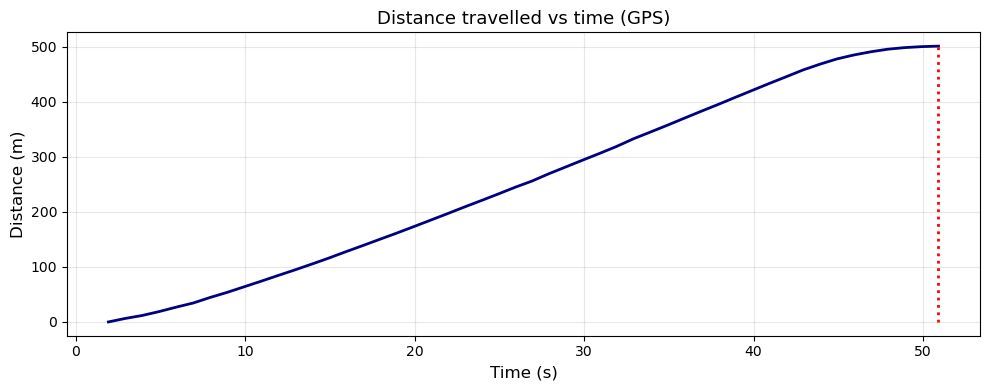

total distance traveld = 501.5689015000001 m
total time traveld = 50.91223907 s


In [34]:
# -1 is the last recorded but it has NaN so its not useable.
final_time = gps["time"].iloc[-2]
final_distance = gps["d_m"].iloc[-2]

plt.figure(figsize=(10,4))

plt.plot(gps["time"],gps["d_m"],linewidth=2,color="navy")
plt.vlines(x=final_time, ymin=0, ymax=final_distance, colors="red", linestyles="dotted",linewidth=2,label="Total distance")

plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Distance (m)", fontsize=12)
plt.title("Distance travelled vs time (GPS)", fontsize=13)
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

print ( "total distance traveld =", final_distance, "m" )
print ( "total time traveld =", final_time, "s" )

In [35]:
total_distance = gps["d_m"].iloc[-2]
total_time = gps["time"].iloc[-2] - gps["time"].iloc[0]

avg_speed_kmh = (total_distance / total_time) * 3.6
max_speed_kmh = gps["v_ms"].max() * 3.6

print (avg_speed_kmh, max_speed_kmh)


36.85169313252081 45.635003964000006


In [36]:
from IPython.display import display, HTML

display(HTML(f"<b>Average speed:</b> {avg_speed_kmh:.1f} km/h"))
display(HTML(f"<b>Maximum speed:</b> {max_speed_kmh:.1f} km/h"))


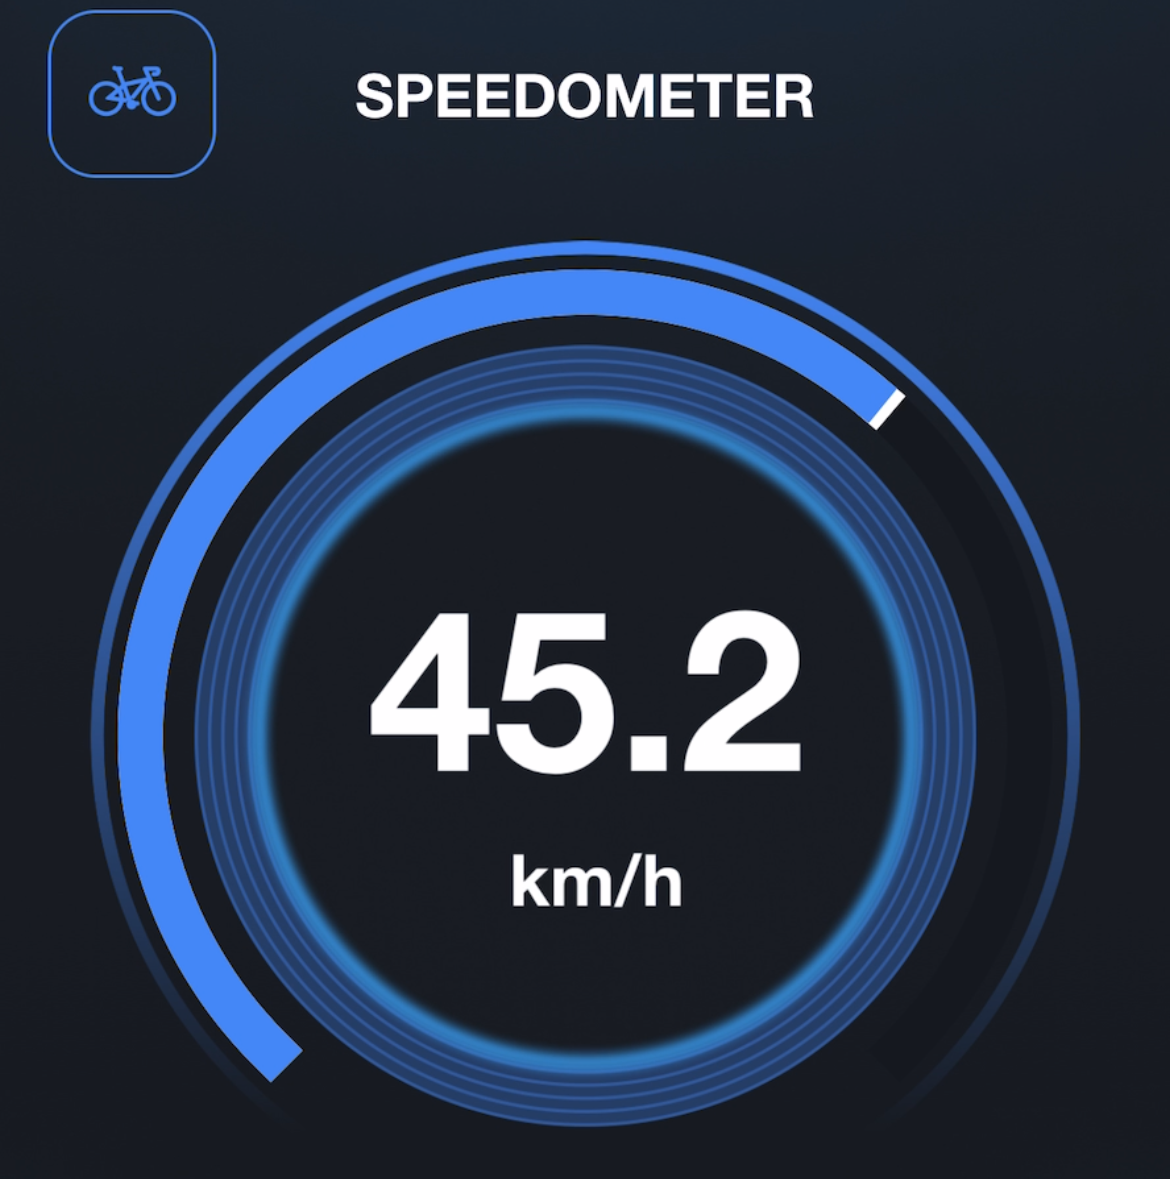

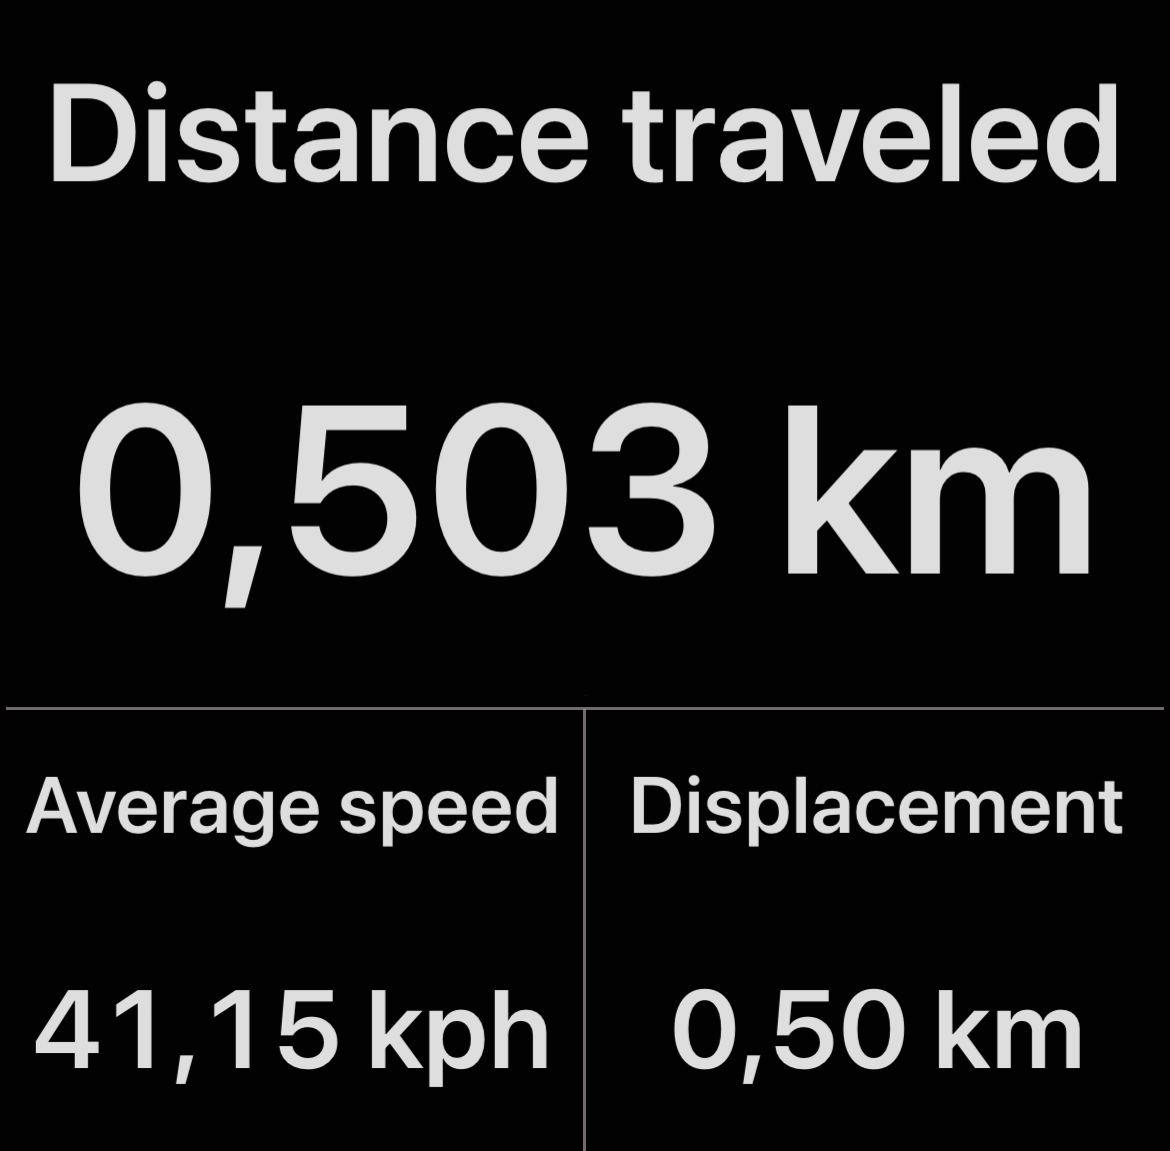

In [40]:
from IPython.display import Image, display

display(Image(filename="top speed.png", width=500))
display(Image(filename="avrage speed and distance.png", width=500))


## Discussion

The average and maximum speed of the scooter were determined using GPS data from a straight-line ride of approximately 500 m.  
The analysis resulted in an average speed of **36.9 km/h** and a maximum speed of **45.6 km/h**.

Two separate smartphone applications measured an average speed of **41.15 km/h** and a maximum speed of **45.2 km/h** on the same route.  
The maximum speed values are very similar, indicating that GPS measurements are reliable for determining peak speed.

The average speed obtained from the Python analysis is lower than the values reported by the applications.  
This difference can be explained by GPS accuracy, measurement noise, and differences in data processing methods used by the apps, such as smoothing or filtering.


### The twist

The straight-line ride provides a controlled measurement situation.  
However, in real-life conditions, scooter riding often takes place in urban environments where turns, stops, and traffic significantly affect the speed profile.

To investigate this effect, the same analysis method is applied to a ride through the city.


In [41]:
gps_city = pd.read_csv("Raw Data GPS S.csv")
gps_city.head()


,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,0.005393,51.476668,5.669683,18.955732,63.277283,0.0186,56.482752,0.001130,4.767842,3.330498,-1.0
1,0.609903,51.476661,5.669695,14.579983,58.901559,0.3900,70.312500,0.002410,6.471502,6.000000,-1.0
2,2.069927,51.476658,5.669713,16.692898,61.014491,0.1500,NaN,0.003613,4.485661,4.000000,-1.0
3,3.069951,51.476647,5.669717,16.236599,60.558225,0.3900,83.671875,0.005895,3.680666,3.000000,-1.0
4,4.069974,51.476656,5.669747,15.783474,60.105087,1.4900,57.304688,0.009786,3.535534,3.000000,-1.0


In [42]:
gps_city = gps_city.rename(columns={"Time (s)": "time","Speed (m/s)": "v_ms","Distance (km)": "d_km"})
gps_city[["time", "v_ms", "d_km"]].head()


,time,v_ms,d_km
0,0.005393,0.0186,0.001130
1,0.609903,0.3900,0.002410
2,2.069927,0.1500,0.003613
3,3.069951,0.3900,0.005895
4,4.069974,1.4900,0.009786


In [43]:
gps_city = gps_city.dropna(subset=["v_ms"]).reset_index(drop=True)
gps_city[["time", "v_ms", "d_km"]].head()

,time,v_ms,d_km
0,0.005393,0.0186,0.001130
1,0.609903,0.3900,0.002410
2,2.069927,0.1500,0.003613
3,3.069951,0.3900,0.005895
4,4.069974,1.4900,0.009786


In [ ]:
gps_city["d_m"] = (gps_city["d_km"] - gps_city["d_km"].iloc[0]) * 1000
gps_city[["time", "d_km", "d_m"]].head()


,time,d_km,d_m
0,0.005393,0.001130,0.000000
1,0.609903,0.002410,1.279961
2,2.069927,0.003613,2.482383
3,3.069951,0.005895,4.764350
4,4.069974,0.009786,8.655638


In [ ]:
total_distance_city = gps_city["d_m"].iloc[-3]
total_time_city = gps_city["time"].iloc[-3] - gps_city["time"].iloc[0]

avg_speed_city = (total_distance_city / total_time_city) * 3.6
max_speed_city = gps_city["v_ms"].max() * 3.6

print (avg_speed_city, max_speed_city)


27.73145946549451 40.036787388


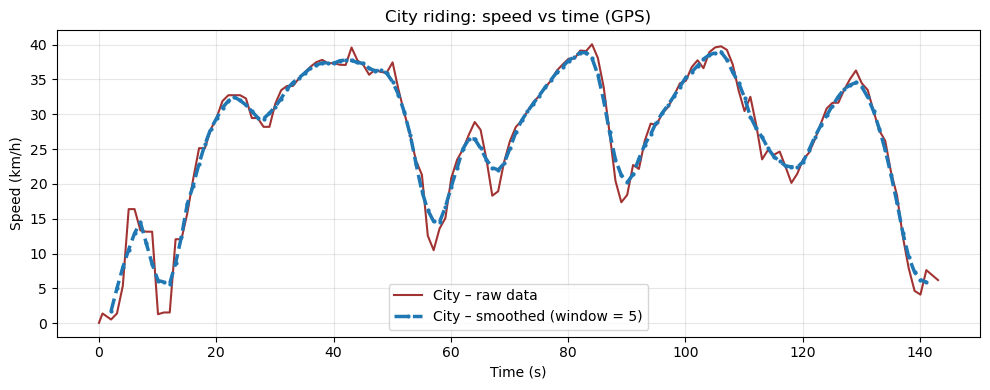

In [44]:
w = 5  

speed_city_kmh = gps_city["v_ms"] * 3.6
speed_city_smooth = speed_city_kmh.rolling(window=w, center=True).mean()

plt.figure(figsize=(10,4))

plt.plot(gps_city["time"], speed_city_kmh, linewidth=1.5, alpha=0.8, color="darkred", label="City – raw data")

plt.plot(gps_city["time"], speed_city_smooth, linewidth=2.5, linestyle="--", marker=".", markersize=4,label=f"City – smoothed (window = {w})")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("City riding: speed vs time (GPS)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


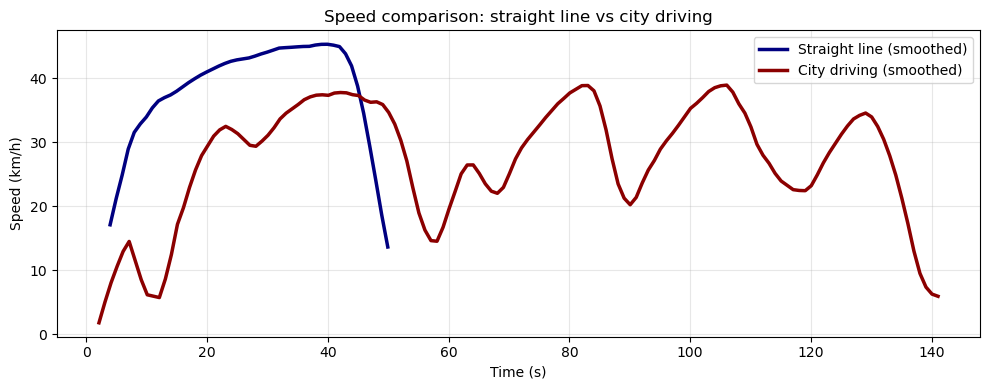

In [ ]:
w = 5

speed_straight_kmh = gps["v_ms"] * 3.6
speed_straight_smooth = speed_straight_kmh.rolling(window=w, center=True).mean()

speed_city_kmh = gps_city["v_ms"] * 3.6
speed_city_smooth = speed_city_kmh.rolling(window=w, center=True).mean()

plt.figure(figsize=(10,4))


plt.plot(gps["time"], speed_straight_smooth, linewidth=2.5, color="navy", label="Straight line (smoothed)")


plt.plot(gps_city["time"], speed_city_smooth, linewidth=2.5, color="darkred", label="City driving (smoothed)")

plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Speed comparison: straight line vs city driving")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#AI usage: AI was used to help debug the code and reduce mistakes caused by complex syntax, such as brackets and nested commands. 
#This support helped achieve a cleaner and more readable final result.
#from IPython.display import display, HTML

display(HTML(f"""<b>Straight-line ride:</b><br>
Average speed = {avg_speed_kmh:.1f} km/h<br>
Maximum speed = {max_speed_kmh:.1f} km/h
<br><br>
<b>City ride:</b><br>
Average speed = {avg_speed_city:.1f} km/h<br>
Maximum speed = {max_speed_city:.1f} km/h"""))


## Comparison: straight-line ride vs. city riding

The straight-line ride shows a relatively stable speed with only small variations, whereas the city ride exhibits frequent speed changes caused by traffic, turns, and stopping.  
As a result, the average speed during city riding is lower, while the maximum speed remains similar to that of the straight-line ride.

This comparison highlights the strong influence of real-world conditions on scooter motion.


## Conclusion

In this study, smartphone GPS data was used to determine the average and maximum speed of a scooter.  
The straight-line measurements provided controlled conditions and showed reliable maximum speed values, while the average speed was influenced by acceleration and braking.

By comparing these results with city riding, it was shown that real-world factors such as traffic and route complexity significantly affect the scooter’s speed.  
This demonstrates the importance of measurement conditions when analysing motion.

*fun fact: now if i get stopped by police i have concrete proof of my speed!


In [45]:
%reset -f
